# L0 data clean

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import imp
import datetime
import pytz
%matplotlib notebook

In [4]:
import imp
import LVL1

In [5]:
#Read in data
Glacier= 'Gulkana' #Capitalized glacier name
Station= '1920' #elevation of station
folder=r"Q:/Project Data/GlacierData/Benchmark_Program/Data/" + Glacier+ "/AllYears/Wx/Raw" #folder cont
file_label='_15min_' #used for importting and output name
yr='all'
file=Glacier.lower()+Station+file_label+yr+".csv" #filename; change if yours different
pth=os.path.join(folder, file) #path to data file

In [6]:
#Set constants
date_format='%m/%d/%Y %H:%M:%S' #input date format (change if yours is different)
out_date_format='%Y/%m/%d %H:%M'
timezone='America/Anchorage' #choose from pytz.all_timezones

In [7]:
dat=pd.read_csv(pth)
print("read file: " + pth)

read file: Q:/Project Data/GlacierData/Benchmark_Program/Data/Gulkana/AllYears/Wx/Raw\gulkana1920_15min_all.csv


In [8]:
dat.tail()

,DateTime,variable,value
2586379,2017-04-19 15:30:00,BattV_Avg,14.60
2586380,2017-04-19 15:30:00,BP_inHg_Avg,23.56
2586381,2017-04-19 15:30:00,AirTempC_Avg,-11.68
2586382,2017-04-19 15:30:00,WindDir_D1_WVT,352.00
2586383,2017-04-19 15:30:00,WindDir_SD1_WVT,9.10


## Convert Logger time to UTC and Local Time

In [32]:
#Logger records on UTC -8; convert to local time
#Create date-time column
#dat['DateTime']=dat.Date+ " " + dat.Time #this is needed for non-cumulative processing
dat.loc[:,'DateTime']=pd.to_datetime(dat['DateTime'], format=date_format) #set to date-time from string

#Correct for time slips
dat['DateTime']=dat['DateTime'].dt.round('15min') #round time to the nearest 15 minute value

#Convert to UTC time, if logger is logging in UTC-8 (true at some stations)
if (Glacier+Station=='Wolverine990') | (Glacier+Station=='Gulkana1480'):
    dat['UTC_col']=dat.DateTime + datetime.timedelta(hours=8)
if (Glacier+Station=='Gulkana1725'):
    dat['UTC_col']=dat.DateTime #logger is already in UTC time
#Set timezone of known UTC column
dat['UTC_col'].timezone='UTC'
#Create column for local time
local_timezone=pytz.timezone(timezone) #create local timezone object (e.g. AK time)

dat=dat.set_index('UTC_col')
#Create column for local time
local_timezone=pytz.timezone(timezone) #create local timezone object (e.g. AK time)

#Create local time
dat['local_time'] = dat.index.tz_localize('UTC').tz_convert(local_timezone)

dat['index_local_time']=dat.local_time.copy()

In [33]:
#Set index to local time
dat=dat.set_index('index_local_time')

In [34]:
#Drop duplicates that have same instrument name and date/time stamp (from multiple downloads of same portion of data)
dat=dat.drop_duplicates(subset=['DateTime', 'Instrument'], keep='first') #gets rid of overlaps (i.e. multiple downloads of same bit of data)

In [35]:
#Instrument Label Change - if same label has been used for different quantities thru time: separate into 2 distinct labels.
if Glacier + Station=="Wolverine990":
    dat.loc[(dat.Instrument=='WD') & (dat.index<'2015-09-06 17:15'), 'Instrument']='WindDir' #before this date, "WD" was simply wind direction; after, is vector-averaged
    dat.loc[(dat.Instrument=='WD') & (dat.index>='2015-09-06 17:15'), 'Instrument']='WDSA' 
    
if Glacier + Station=="Gulkana1480":
    dat.loc[(dat.Instrument=='WD') & (dat.index<'2015-09-28 12:00'), 'Instrument']='WindDir' #before this date, "WD" was simply wind direction; after, is vector-averaged
    dat.loc[(dat.Instrument=='WD') & (dat.index>='2015-09-28 12:00'), 'Instrument']='WDSA' 
    
#Gulkana 1725 has had consistent variable naming throughout

## Consolidate Sensor Naming
#### Has varied thru time

In [36]:
#If site does NOT have a given sensor, leave label, create empty list

if Glacier + Station =='Wolverine990':  
    #Name recorded on the logger changed thru time; indicate which are grouped (i.e. logging same variable) here
    wind_gust_labels=['WindGusts', 'WG', 'WSG']
    wind_speed_labels=['AvgWind', 'WS'] #this is NOT vector-averaged wind speed
    vec_avg_wind_speed=['WDSA']
    wind_dir_labels=['WindDir']
    temp_unasp1_labels=['AirTemp1', 'T1', 'T']
    temp_unasp2_labels=['AirTemp2', 'T2']
    temp_asp1_labels=['AirTempAsp', 'AspT', 'AT']
    temp_asp2_labels=['ASPTRH', 'AT2']
    precip_stage_labels=['PR']
    precip_weighing_labels=['TPG', 'PC']
    rel_hum_labels=['RH']
    barometer_labels=['B']
    logger_bat_label=['BV']
    logger_temp_label=['Tinternal']
    bad_labels=['PrecipStage', 'AirTemp3', 'Air Temp w/FanN', 'AirTemp w/Fan', 'VectorAvgWindDir', 'PS', 'MWD', 'WDA'] #labels containing only bad data; introduced during maintenence etc.
    radiation_up_labels=[]
    radiation_down_labels=[]
    snow_depth_labels=[] 
    
if Glacier + Station =='Gulkana1480':  
    #Name recorded on the logger changed thru time; indicate which are grouped (i.e. logging same variable) here
    wind_gust_labels=['WSG']
    wind_speed_labels=['WindSpeed', 'WS']
    vec_avg_wind_speed=['WDSA']
    wind_dir_labels=['WindDir'] #this is NOT-vector average wind direction
    temp_unasp1_labels=['AirTemp1', 'T1', 'T']
    temp_unasp2_labels=['AirTemp2', 'T2']
    temp_asp1_labels=['AspT', 'AT']
    temp_asp2_labels=['AT2']
    precip_stage_labels=['PR'] #precip doesn't begin until 2010-07; before this, is recording, but logger only has 0 precip
    precip_weighing_labels=['TPG', 'PC']
    rel_hum_labels=['RH']
    barometer_labels=[] #no barometer at this station
    logger_bat_label=['BV']
    logger_temp_label=['Tinternal']
    bad_labels=['PrecipStage', 'AirTemp3'] #labels containing only bad data; introduced during maintenence etc.
    radiation_up_labels=[]
    radiation_down_labels=[]
    snow_depth_labels=[]    
    
if Glacier + Station=='Gulkana1725':
    #Only a single name thru time; no changes @ 1725
    wind_gust_labels=[]#no wind gust recorded
    wind_speed_labels=['MS']
    vec_avg_wind_speed=['MD']
    wind_dir_labels=[] #this is NOT-vector average wind direction
    temp_unasp1_labels=['T']
    temp_unasp2_labels=[]
    temp_asp1_labels=['TA']
    temp_asp2_labels=[]
    precip_stage_labels=[]
    precip_weighing_labels=['PC']
    rel_hum_labels=[]
    barometer_labels=[] #no barometer at this station
    logger_bat_label=['VB']
    logger_temp_label=[]
    bad_labels=[]
    radiation_up_labels=['RU']
    radiation_down_labels=['RD']
    snow_depth_labels=['DS']
    

In [37]:
#Rename instruments 
dat.loc[dat.Instrument.isin(wind_gust_labels), "Instrument"]='WindGustSpeed'
dat.loc[dat.Instrument.isin(wind_speed_labels), "Instrument"]='WindSpeed'
dat.loc[dat.Instrument.isin(wind_dir_labels), "Instrument"]='WindDir'
dat.loc[dat.Instrument.isin(vec_avg_wind_speed), "Instrument"]='VecAvgWindDir'
dat.loc[dat.Instrument.isin(temp_unasp1_labels), "Instrument"]='Tpassive1'
dat.loc[dat.Instrument.isin(temp_unasp2_labels), "Instrument"]='Tpassive2'
dat.loc[dat.Instrument.isin(temp_asp1_labels), "Instrument"]='TAspirated1'
dat.loc[dat.Instrument.isin(temp_asp2_labels), "Instrument"]='TAspirated2'
dat.loc[dat.Instrument.isin(precip_stage_labels), "Instrument"]='StageCumulative'
dat.loc[dat.Instrument.isin(precip_weighing_labels), "Instrument"]='TPGCumulative'
dat.loc[dat.Instrument.isin(rel_hum_labels), "Instrument"]='RelHum'
dat.loc[dat.Instrument.isin(barometer_labels), "Instrument"]='Barom'
dat.loc[dat.Instrument.isin(logger_bat_label), "Instrument"]='LoggerBattery'
dat.loc[dat.Instrument.isin(logger_temp_label), "Instrument"]='LoggerTemp'
dat.loc[dat.Instrument.isin(radiation_up_labels), "Instrument"]='RadiationIn'
dat.loc[dat.Instrument.isin(radiation_down_labels), "Instrument"]='RadiationOut'
dat.loc[dat.Instrument.isin(snow_depth_labels), "Instrument"]='SnowDepth'

#Remove rows with bad data
dat=dat[~dat.Instrument.isin(bad_labels)] #Remove where labels are bad; introduced during maintenance

In [54]:
#Cast the data from long -> wide format
dat=dat.reset_index() #reset index so all unique
wide_dat=dat.pivot_table(columns='Instrument', values='Value', index='local_time')

In [55]:
#List columns desired in output
out_columns=['UTC_time', 'AK_time', 'Tpassive1', 'Tpassive2',
       'TAspirated1', 'TAspirated2', 'RelHum', 'StageCumulative',
       'TPGCumulative', 'WindSpeed', 'WindGustSpeed', 'WindDir', 
        'VecAvgWindDir', 'RadiationIn', 'RadiationOut', 'SnowDepth', 'LoggerTemp', 'LoggerBattery']

In [56]:
#If this columns is not in dataframe, create
for col in out_columns:
    if col not in wide_dat.columns:
        wide_dat[col]=np.nan #create the column; fill with NANs

In [57]:
#Set output format of time
wide_dat['UTC_time']=wide_dat.index.tz_convert('UTC').strftime(out_date_format)#Create column for true local time (as string, not UTC - X hrs)
wide_dat['AK_time']=wide_dat.index.tz_convert('America/Anchorage').strftime(out_date_format)#Create column for true local time (as string, not UTC - X hrs)

In [58]:
wide_dat.tail(1)

Instrument,LoggerBattery,RadiationIn,RadiationOut,SnowDepth,TAspirated1,TPGCumulative,Tpassive1,VecAvgWindDir,WindSpeed,UTC_time,AK_time,Tpassive2,TAspirated2,RelHum,StageCumulative,WindGustSpeed,WindDir,LoggerTemp
local_time,,,,,,,,,,,,,,,,,,
2017-08-22 21:00:00-08:00,12.9,4.03,2.71,2.156,5.2,4.2948,6.0,6.0,1.2,2017/08/23 05:00,2017/08/22 21:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [46]:
wide_dat=wide_dat.reset_index(drop=True).copy() #drop index in output dataframe

In [47]:
save_dat=wide_dat[out_columns]

In [48]:
#directory to save output data
save_pth=r"Q:/Project Data/GlacierData/Benchmark_Program/Data/" +Glacier+ r"/AllYears/Wx/LVL0/emily/"

In [49]:
out_nm=Glacier.lower()+ Station + file_label+yr+".csv"

In [50]:
save_dat.to_csv(os.path.join(save_pth, out_nm), index=False, float_format='%g')
print("saved to: ", os.path.join(save_pth, out_nm))

saved to:  Q:/Project Data/GlacierData/Benchmark_Program/Data/Gulkana/AllYears/Wx/LVL0/emily/gulkana1725_15min_all.csv


In [51]:
save_dat.columns

Index(['UTC_time', 'AK_time', 'Tpassive1', 'Tpassive2', 'TAspirated1',
       'TAspirated2', 'RelHum', 'StageCumulative', 'TPGCumulative',
       'WindSpeed', 'WindGustSpeed', 'WindDir', 'VecAvgWindDir', 'RadiationIn',
       'RadiationOut', 'SnowDepth', 'LoggerTemp', 'LoggerBattery'],
      dtype='object', name='Instrument')

<IPython.core.display.Javascript object>


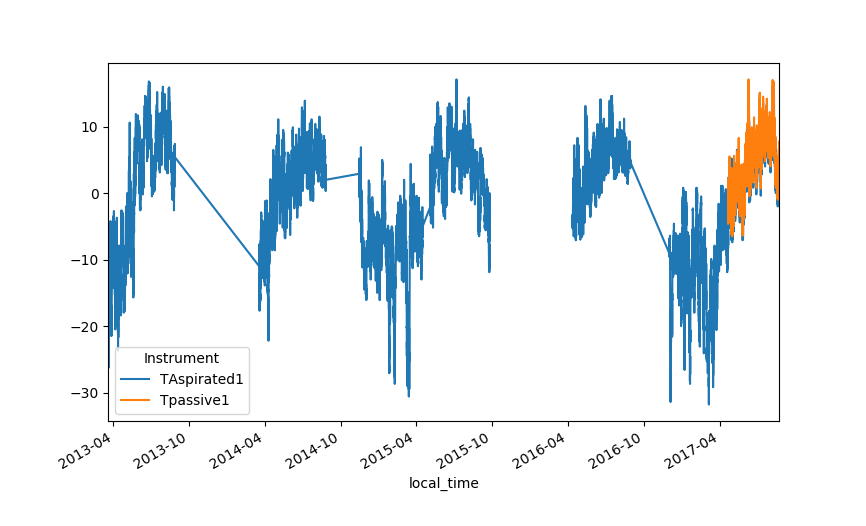

In [62]:
wide_dat[['TAspirated1', 'Tpassive1']].plot()

In [64]:
wide_dat

Instrument,LoggerBattery,RadiationIn,RadiationOut,SnowDepth,TAspirated1,TPGCumulative,Tpassive1,VecAvgWindDir,WindSpeed,UTC_time,AK_time,Tpassive2,TAspirated2,RelHum,StageCumulative,WindGustSpeed,WindDir,LoggerTemp
local_time,,,,,,,,,,,,,,,,,,
2013-03-19 16:45:00-08:00,14.2,NaN,NaN,NaN,-24.1,NaN,NaN,253.0,7.6,2013/03/20 00:45,2013/03/19 16:45,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-03-19 17:00:00-08:00,14.1,-2.10,-0.58,1.870,-24.5,NaN,NaN,268.0,6.1,2013/03/20 01:00,2013/03/19 17:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-03-19 17:15:00-08:00,14.1,-1.93,-0.19,1.860,-24.0,NaN,NaN,267.0,5.1,2013/03/20 01:15,2013/03/19 17:15,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-03-19 17:30:00-08:00,14.1,-1.58,-0.19,1.870,-24.0,NaN,NaN,262.0,4.9,2013/03/20 01:30,2013/03/19 17:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-03-19 17:45:00-08:00,14.0,-1.93,-0.39,1.860,-23.9,NaN,NaN,255.0,5.7,2013/03/20 01:45,2013/03/19 17:45,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-03-19 18:00:00-08:00,14.0,-1.93,-0.39,1.870,-24.1,NaN,NaN,263.0,5.5,2013/03/20 02:00,2013/03/19 18:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-03-19 18:15:00-08:00,14.0,-1.23,0.00,1.860,-24.0,NaN,NaN,241.0,7.7,2013/03/20 02:15,2013/03/19 18:15,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-03-19 18:30:00-08:00,13.9,-1.05,0.19,1.870,-23.5,NaN,NaN,243.0,6.9,2013/03/20 02:30,2013/03/19 18:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-03-19 18:45:00-08:00,13.9,-0.88,0.19,1.870,-24.1,NaN,NaN,261.0,5.8,2013/03/20 02:45,2013/03/19 18:45,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [77]:
wide_dat['2013-03-25 00']

Instrument,LoggerBattery,RadiationIn,RadiationOut,SnowDepth,TAspirated1,TPGCumulative,Tpassive1,VecAvgWindDir,WindSpeed,UTC_time,AK_time,Tpassive2,TAspirated2,RelHum,StageCumulative,WindGustSpeed,WindDir,LoggerTemp
local_time,,,,,,,,,,,,,,,,,,
2013-03-25 00:00:00-08:00,13.1,-0.88,0.00,1.79,-4.2,NaN,NaN,7.0,7.6,2013/03/25 08:00,2013/03/25 00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-03-25 00:15:00-08:00,13.1,-0.88,-0.39,1.79,-4.4,NaN,NaN,7.0,6.5,2013/03/25 08:15,2013/03/25 00:15,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-03-25 00:30:00-08:00,13.1,-0.35,0.19,1.79,-4.3,NaN,NaN,7.0,6.8,2013/03/25 08:30,2013/03/25 00:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-03-25 00:45:00-08:00,13.1,-0.53,-0.19,1.80,-4.3,NaN,NaN,7.0,6.9,2013/03/25 08:45,2013/03/25 00:45,NaN,NaN,NaN,NaN,NaN,NaN,NaN
